
**참고자료**
<br>
<br>
 * https://somjang.tistory.com/entry/Keras%EA%B8%B0%EC%82%AC-%EC%A0%9C%EB%AA%A9%EC%9D%84-%EA%B0%80%EC%A7%80%EA%B3%A0-%EA%B8%8D%EC%A0%95-%EB%B6%80%EC%A0%95-%EC%A4%91%EB%A6%BD-%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0
<br>
<br>
 * https://github.com/sbomhoo/naver_news_crawling/blob/master/README.md

# 뉴스 기사 이슈분석 지표 (WordCloud)

## 데이터 불러오기
<br>

**데이터 특성 정의( 각각의 데이터가 어떤 특성을 가지는지? )**

    ▶ date : 등록된 기사별 날짜
    ▶ title : 기사 제목
    ▶ source : 언론사
    ▶ contents : 기사 내용 요약본
    ▶ link : 사이트 주소

※ : 네이버 뉴스 기준으로 Test... ( 구글 뉴스데이터와 병합해서 전처리 실시 예정 )

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime, time
import re
import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 시각화 글자 깨짐 방지
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
matplotlib.rc('font',family='NanumGothic')

# 한글 폰트 적용
matplotlib.rc('axes', unicode_minus = False) # True

# 2022 / 04 / 21 일자 스크래핑 데이터
df_news = pd.read_csv('./news_data.csv', engine= 'python',encoding = 'utf-8')

# (행, 열)
print(df_news.shape)
df_news.head(1)

(12867, 12)


,Unnamed: 0,date,title,source,contents,link,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,http://www.g-enews.com/ko-kr/news/article/news...,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 데이터 구조 파악시 용이
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   12867 non-null  int64 
 1   date         12867 non-null  object
 2   title        12867 non-null  object
 3   source       12867 non-null  object
 4   contents     12864 non-null  object
 5   link         12867 non-null  object
 6   Unnamed: 6   108 non-null    object
 7   Unnamed: 7   65 non-null     object
 8   Unnamed: 8   14 non-null     object
 9   Unnamed: 9   14 non-null     object
 10  Unnamed: 10  6 non-null      object
 11  Unnamed: 11  5 non-null      object
dtypes: int64(1), object(11)
memory usage: 1.2+ MB


# 데이터 전처리

## 이상치와 결측치 제거 / 데이터 특성(구조) 확인
    ▶ 필요없는 컬럼 제거
    ▶ 컬럼명과 순서 변경 
    ▶ 데이터 구조 파악 - info, head
    
    ▶ 우선 'DGB대구은행'과 필요없는 언론사는 버리고 인덱스번호도 초기화 시켜야 함.
    예를 들면, 축구관련 기사

    제목과 요약본 기준
    '감독' / '신태용' / 'DGB대구은행파크' / '대표팀' / '경기' / '스포츠' / '축구'
    참고 사이트 : https://jimmy-ai.tistory.com/92
※ : 수치별 데이터가 아니므로 이상치는 굳이 확인할 필요가 없다고 판단

In [5]:
# 필요한 데이터만 추출
df_news = df_news.loc[:,['date', 'title', 'source', 'contents']]

# 컬럼명 변경
df_news.rename(columns={'source' : 'press'}, inplace=True)

In [6]:
df_news.head(1)

,date,title,press,contents
0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...


In [7]:
# 행별로 null값 존재 유무 파악 --> 결측치 없음.
df_news.isnull().sum(axis = 0)

date        0
title       0
press       0
contents    3
dtype: int64

In [8]:
# 중복행 제거 --> 분석하는데 안 좋을 수도 있으니 신중한 고려가 필요함.
# 참고 : https://sy-log.tistory.com/60

print(df_news.shape)
print(df_news.duplicated().sum())

# 651 --> 269로 줄어듬.
df_news.drop_duplicates().head(3)

(12867, 4)
184


,date,title,press,contents
0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...
1,2021.05.01.,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",경북신문,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...
2,2021.05.01.,은행·비은행 동반성장…지방금융지주 1분기 '好好好',미디어펜,DGB금융의 순이익은 지난해 1분기에 견줘 40% 급증했다. 핵심 계열사인 대구은행...


In [9]:
# AND용
# target_string = ['서울', '마포']
# df[df['주소'].map(lambda x: all(string in x for string in target_string))]

In [13]:
# df.query('주소.str.contains("마포|은평")', engine='python'
# Series 내장함수 : str.contains() 

# 제목
remove_title = list(df_news.query('title.str.contains("감독|신태용|대표팀|친선경기|스포츠|축구")', engine = 'python').index)
df_news.drop(remove_title, axis=0, inplace = True)

# 내용 요약본
# remove_contents = list(df_news.query('contents.str.contains("감독|신태용|대표팀|친선경기|스포츠|축구")', engine = 'python').index)
# df_news.drop(remove_contents, axis=0, inplace = True)


In [14]:
df_news.shape

(12267, 4)

In [15]:
# 인덱스 번호 새로 부여.
df_news.reset_index(inplace=True)
df_news.drop(['index'], axis=1, inplace=True)

In [16]:
df_news.tail(5)

,date,title,press,contents
12262,4일 전,"DGB대구은행, 선거비용 관리 전용 ‘DGB당선통장’ 판매",경상매일신문,DGB대구은행은 오는 6월1일 ‘제8회 전국동시지방선거’를 앞두고 선거 자금을 관리...
12263,4일 전,"대구은행, 선거 자금 관리 '당선 통장' 판매",대구신문,DGB대구은행은 오는 6월1일 '제8회 전국동시지방선거'를 앞두고 선거 자금을 관리...
12264,4일 전,"DGB대구은행, 선거자금 관리 전용 ‘DGB당선통장’ 판매",뉴데일리,뉴데일리 강승탁 기자 = DGB대구은행(은행장 임성훈)은 오는 6월 1일 ‘제8회 ...
12265,4일 전,"DGB대구은행, ‘ESG경영 실천’ 종량제 봉투 나눔 캠페인 실시",뉴데일리,뉴데일리 강승탁 기자 = DGB대구은행(은행장 임성훈)은 2022년 한 해를 ESG...
12266,4일 전,"DGB대구은행, ‘포스트 팬데믹’ 가정의 달 행사 ‘풍성’",뉴데일리,뉴데일리 강승탁 기자 = DGB대구은행(은행장 임성훈)은 ‘가정의 달’ 5월을 맞아...


## 날짜 데이터 정제 --> 생략가능
    ▶ 연월일로만 표현 ( 시간 제거 )
    ▶ 연 / 월 / 일 3개의 파생변수 생성
    ▶ 연 / 일 보다는 월별로 각 언론사의 'DGB대구은행'에 관련된 기사가 얼마나 많은지? 파악하기 위함. --> 긍정 / 부정 개수로 이어짐.

In [77]:
# 연도별 월별 일별로 
df_news['date']

0      2022.04.01.
1      2022.04.01.
2      2022.04.01.
3      2022.04.01.
4      2022.04.01.
          ...     
329    2022.04.11.
330    2022.04.11.
331    2022.04.11.
332    2022.04.11.
333         21시간 전
Name: date, Length: 334, dtype: object

In [78]:
now = time.localtime()

# 테스트 용 / 참고 - https://wikidocs.net/104836
print(datetime.datetime.now())
print('{}년 {}월 {}일'.format(now.tm_year, now.tm_mon, now.tm_mday-1))
print(pd.to_datetime(df_news['date'][0]) - datetime.timedelta(days = 6))

2022-05-10 10:47:27.441437
2022년 5월 9일
2022-03-26 00:00:00


In [79]:
# 2022-04-21 17:45 일자 데이터 자료 ( 시각은 무시 )
scrapping_date = datetime.date(2022, 4, 21)

idx_list = list()

for i in range(len(df_news['date'])):
    if '일' in df_news['date'][i]:
        idx_list.append(i)
    elif '시간' in df_news['date'][i]:
        idx_list.append(i)
# df_news['date'][i]
# 몇 일전 / 몇 시간전 인덱스 번호

In [80]:
# 시간 전 / 몇일 전 --> 숫자로 변환

for i in idx_list:
    # '\d+'은 정수만 추출
    trans_day = int(re.findall('\d+', df_news['date'][i])[0]) 
    # 시간 전은 -1일로 통일?
    if '시간' in df_news['date'][i]:
        df_news['date'][i] = scrapping_date - datetime.timedelta(days=1)
    else:
        df_news['date'][i] = scrapping_date - datetime.timedelta(days=trans_day)

In [81]:
df_news['date'] = pd.to_datetime(df_news['date'])

In [82]:
df_news['year'] = df_news['date'].dt.year
df_news['month'] = df_news['date'].dt.month
df_news['day'] = df_news['date'].dt.day

In [83]:
df_news.head(1)

,date,title,press,contents,year,month,day
0,2022-04-01,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...,2022,4,1


In [84]:
# 데이터 자료 시간에서 마이너스해주면 날짜가 나옴.
# 이것을 다시 대입해주면 날짜 데이터 정제 완료

# 컬럼 제거 axis = 1 --> 열 / axis = 0 --> 행
# df_news.drop(['date_day'], axis=1, inplace=True)

In [85]:
# 참고 : https://hogni.tistory.com/51
# 컬럼 순서 정렬
df_news = df_news[['date', 'year', 'month', 'day', 'title', 'press', 'contents']]

In [86]:
df_news.head()

,date,year,month,day,title,press,contents
0,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022-04-01,2022,4,1,"DGB대구은행, 기업개선경영 전문역·경영컨설턴트 모집",아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...
3,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역(PCM)·경영컨설턴트 모집",CNB뉴스,"▲ CNB,씨앤비,시앤비,CNB뉴스,씨앤비뉴스 DGB대구은행(은행장 임성훈)는 오는..."
4,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역·경영컨설턴트 모집",NSP통신,"최병수 기자, DGB대구은행(139130)는 오는 4일부터 15일까지 ‘기업경영개선..."


# 형태소 분석

    ▶ 혼자 자립해서 쓸 수 있는 말이 바로 ‘단어’ 이고, 단어를 더 쪼갠 것을 ‘형태소’
    
    ▶ 언론사를 각 숫자로 표현 후 EDA 실시 Ex) 1 : 미디어펜, 2 : 아이뉴스24, 3 : 데일리안 ...
    
    ▶ date : 등록된 기사별 날짜
    
**참고사이트 : https://mr-doosun.tistory.com/22 / https://konlpy.org/ko/v0.4.3/morph/**

In [87]:
df_news.head()

,date,year,month,day,title,press,contents
0,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022-04-01,2022,4,1,"DGB대구은행, 기업개선경영 전문역·경영컨설턴트 모집",아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...
3,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역(PCM)·경영컨설턴트 모집",CNB뉴스,"▲ CNB,씨앤비,시앤비,CNB뉴스,씨앤비뉴스 DGB대구은행(은행장 임성훈)는 오는..."
4,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역·경영컨설턴트 모집",NSP통신,"최병수 기자, DGB대구은행(139130)는 오는 4일부터 15일까지 ‘기업경영개선..."


## 정규식 표현 --> 생략가능

<br>

**'[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》]' 등을 기사제목에서 제거**
- tqdm --> 진행률 표시 모듈
<br>

In [92]:
# from tqdm import tqdm
# labels = []

# # 원본 데이터프레임 복사하여 사용

# df_news_copy = df_news.copy()
# title_data = df_news_copy['title'].tolist()

# for i in range(len(title_data)):
#     clean_title = re.sub('[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》→p”“◇證‧]', ' ', title_data[i])
#     df_news_copy.replace({'title':title_data[i]}, clean_title, inplace=True)

# df_news_copy.loc[:5,['title']]

## 형태소 분석기 선택 및 처리

<br>

**Hannanum / Kkma / Komoran / Mecab / Twitter(Okt, 사용?)**
- stem = True --> 동사의 원형을 찾아줌.
- norm = True --> 문장의 정규화 여부를 정하는 옵션
<br>

**참고사이트 : https://konlpy.org/ko/v0.4.3/morph/, https://too-march.tistory.com/15**

In [9]:
stopwords = ['의', '가', '이', '은', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [89]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
X_train = []
for sentence in df_news_copy['title']:
    tmp_X = okt.morphs(sentence, stem=True) # 토큰화
    tmp_X = [word for word in tmp_X if not word in stopwords] # 불용어 제거
    # 대기
    # X_train.append(tmp_X)
    df_news_copy.replace({'title':sentence}, ' '.join(tmp_X), inplace=True) # 공백 기준으로 단어 나누기.

In [90]:
df_news_copy.head(3)

,date,year,month,day,title,press,contents
0,2022-04-01,2022,4,1,대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집,미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022-04-01,2022,4,1,DGB 대구 은행 기업 개선 경영 전문 역 경영 컨설턴트 모집,아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022-04-01,2022,4,1,대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집,데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...


In [91]:
print(df_news_copy.loc[:5, ['title']])
# title 컬럼 --> 공백을 기준으로 나눠 리스트로 변환
title_text = ''
for title_words in df_news_copy['title']:
     # 기사 제목당 단어별 리스트 반환
    # print(list(title_words.split(' ')))
    
    # 워드 클라우드를 위한 단어 병합
    title_text += ' '.join(title_words.split(' '))

                                    title
0          대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집
1      DGB 대구 은행 기업 개선 경영 전문 역 경영 컨설턴트 모집
2          대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집
3  DGB 대구 은행 기업 경영 개선 전문 역 PCM 경영 컨설턴트 모집
4      DGB 대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집
5      DGB 대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집


## 단어 추출 기준
**2가지 기준**
- 글자 길이가 2 이상인 단어
- 빈도수가 10 이상인 단어

In [93]:
# 명사만 추출 - 글자 길이가 2 이상인 단어만 추출
tokens_ko = okt.nouns(title_text) 
tokens_ko = [ ko for ko in tokens_ko if len(ko) > 1 ]
tokens_ko

['대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '개선',
 '경영',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대한민국',
 '잡스',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '개선',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '경영',
 '개선',
 '전문',
 '컨설턴트',
 '공개',
 '채용',
 '임성훈',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '공개',
 '채용',
 '대구',
 '은행',
 '기업',
 '개선',
 '경영',
 '컨설턴트',
 '공개',
 '채용',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '공채',
 '진행',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 

In [95]:
# nltk
ko = nltk.Text(tokens_ko, name='대구맛집')
words_cnt = ko.vocab().most_common()
print('단어의 총 갯수 : {}'.format(len(words_cnt)))

# 카운트가 10 이상인 단어만 추출 --> 마지막에 조절할 수 있음 !
# def select_word(ko_vocab):
#     for idx in range(len(ko_vocab)):
#         for j in ko_vocab[idx][1:]:
#             if j < 10:
#                 print(idx)
#                 return idx

# idx = select_word(words_cnt)
# ko.vocab().most_common(idx)
ko.vocab().most_common(30)

단어의 총 갯수 : 360


[('은행', 273),
 ('대구', 207),
 ('대출', 112),
 ('전세', 93),
 ('금리', 82),
 ('경영', 68),
 ('인하', 66),
 ('제한', 66),
 ('금융', 64),
 ('취급', 62),
 ('해제', 62),
 ('개선', 37),
 ('컨설턴트', 36),
 ('출시', 35),
 ('기업', 34),
 ('전문', 34),
 ('파킹', 31),
 ('통장', 31),
 ('비상', 31),
 ('박스', 31),
 ('지방', 29),
 ('모집', 28),
 ('편의점', 26),
 ('채용', 25),
 ('디지털', 21),
 ('그룹', 20),
 ('혁신', 19),
 ('에너지', 19),
 ('일기', 19),
 ('공모전', 19)]

# 워드클라우드 시각화
- 기사 제목을 기준으로 수행 / 명사만 사용.

In [96]:
# 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

# 모듈 불러오기
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests
from nltk import Text
import nltk

In [97]:
# 기사 제목 병합
print('기사 제목(병합) :', title_text[:20])

기사 제목(병합) : 대구 은행 기업 경영 개선 전문 역 


## 그래프로 빈도수 확인

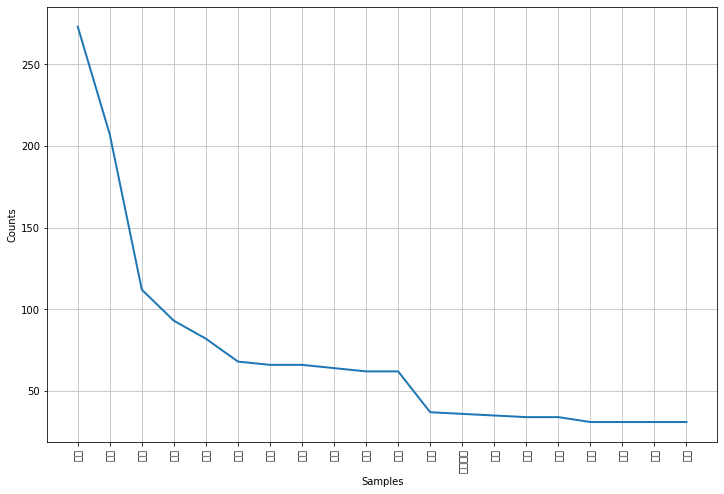

In [98]:
plt.figure(figsize=(12, 8))
ko.plot(20)
plt.show()

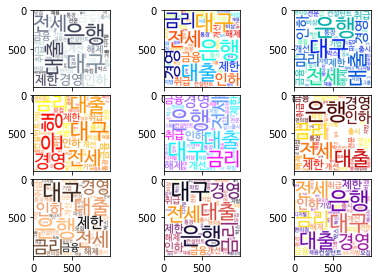

In [101]:
# 색변경 - https://codetorial.net/matplotlib/set_colormap.html
# data = ko.vocab().most_common(idx)

# 상위 50개의 단어로 워드클라우드 표현
data = ko.vocab().most_common(50)
palettes = ['bone', 'jet', 'winter','autumn', 'cool', 'hot', 'copper', 'inferno', 'plasma']
fig,ax = plt.subplots(3, 3)
fig.tight_layout()
axes = [ax[0,0],ax[0,1],ax[0,2], ax[1,0],ax[1,1], ax[1,2], ax[2,0], ax[2,1], ax[2,2]]
plt.subplots_adjust(wspace=0.1, 
                    hspace=0.1)

for i in range(9):
    wordcloud = WordCloud(font_path='NanumBarunGothic.ttf',
                          relative_scaling = 0.2,
                          # stopwords=STOPWORDS,
                          background_color='white',
                          width=1000,
                          height=1000,
                          max_words=100,
                          max_font_size=300,
                          colormap = palettes[i]).generate_from_frequencies(dict(data))
    axes[i].imshow(wordcloud)

# plt.figure(figsize=(10, 10))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

## 최종 결과

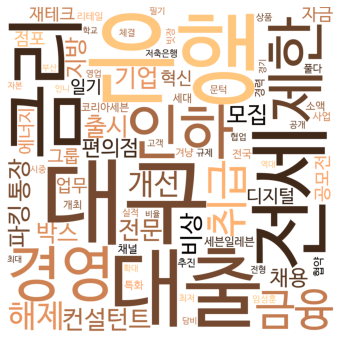

In [110]:
# data = ko.vocab().most_common(idx)
data = ko.vocab().most_common(100)

wordcloud = WordCloud(font_path='NanumBarunGothic.ttf',
                          relative_scaling = 0.2,
                          background_color='white',
                          width=1500,
                          height=1500,
                          max_words=75,
                          max_font_size=450,
                          colormap = 'copper').generate_from_frequencies(dict(data))
# inferno / jet / copper / cool / winter
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()